## Multi-Layer Perceptron (MLP) approach to Matric Factorization

The description here corresponds to Section 3.3 in [Xiangnan He. et al](https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf) paper. 

This will be a much sorter notebook than the Chapter02 because the code related to the training and evaluation phases is identical. Therefore, I will not include it here again. Also note I call them *"Chapters"* just to be consistent with the notation I used when I coded the Ponpare example. There the notebooks are a bit heavier than these and more self-contained. Perhaps the word Chapter makes more sense there than here, but anyway, for consistency I will still use it here. 

Let's go!

In [1]:
import numpy as np
import pandas as pd
import os
import torch
import argparse
import heapq

from time import time
from scipy.sparse import load_npz
from torch import nn
from torch.optim.lr_scheduler import CyclicLR
from torch.utils.data import DataLoader, Dataset
from utils import get_train_instances, get_scores
from gmf import train, evaluate, checkpoint

In [2]:
datadir = "../datasets/Amazon"
dataname = "neuralcf_split.npz"
train_matrix = "neuralcf_train_sparse.npz"
modeldir = "../datasets/Amazon/models"
layers = [128, 64, 32, 16] # first layer is n_emb*2
dropouts = [0., 0., 0.0] # len(dropouts) = len(layers)-1
l2reg = 0.
n_emb = int(layers[0]/2)
batch_size = 512
epochs = 1
learner = "Adam"
lr = 0.01
lr_scheduler = None
validate_every = 1 # boolean
topk = 10
n_neg = 4

### The Model

In [3]:
class MLP(nn.Module):
    def __init__(self, n_user, n_item, layers, dropouts):
        super(MLP, self).__init__()

        self.layers = layers
        self.n_layers = len(layers)
        self.dropouts = dropouts
        self.n_user = n_user
        self.n_item = n_item

        self.embeddings_user = nn.Embedding(n_user, int(layers[0]/2))
        self.embeddings_item = nn.Embedding(n_item, int(layers[0]/2))

        self.mlp = nn.Sequential()
        for i in range(1,self.n_layers):
            self.mlp.add_module("linear%d" %i, nn.Linear(layers[i-1],layers[i]))
            self.mlp.add_module("relu%d" %i, torch.nn.ReLU())
            self.mlp.add_module("dropout%d" %i , torch.nn.Dropout(p=dropouts[i-1]))

        self.out = nn.Linear(in_features=layers[-1], out_features=1)

        for m in self.modules():
            if isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight)

    def forward(self, users, items):

        user_emb = self.embeddings_user(users)
        item_emb = self.embeddings_item(items)
        emb_vector = torch.cat([user_emb,item_emb], dim=1)
        emb_vector = self.mlp(emb_vector)
        preds = torch.sigmoid(self.out(emb_vector))

        return preds

In [4]:
import hiddenlayer as hl

In [5]:
layers

[128, 64, 32, 16]

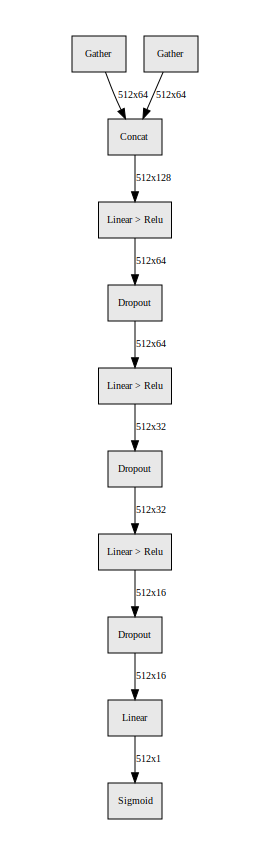

In [6]:
toy_model = MLP(10, 10, layers, dropouts)
hl.build_graph(toy_model, (torch.zeros([batch_size]).long(),  torch.zeros([batch_size]).long()) )

Training and evaluating is exactly the same as in `Chapter02_GMF` so we move directly to Run the Model

### Run the Model

In [8]:
dataset = np.load(os.path.join(datadir, dataname))
train_ratings = load_npz(os.path.join(datadir, train_matrix)).todok()
test_ratings, negatives = dataset['test_negative'], dataset['negatives']
n_users, n_items = dataset['n_users'].item(), dataset['n_items'].item()

test_loader = DataLoader(dataset=test_ratings,
    batch_size=1000,
    shuffle=False
    )

model = MLP(n_users, n_items, layers, dropouts)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2reg)
scheduler = None
criterion = nn.BCELoss()

use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()

In [9]:
best_hr, best_ndcgm, best_iter=0,0,0
for epoch in range(1,epochs+1):
    t1 = time()
    loss = train(model, criterion, optimizer, scheduler, epoch, batch_size,
        use_cuda, train_ratings, negatives, n_items, n_neg)
    t2 = time()
    if epoch % validate_every == 0:
        (hr, ndcg) = evaluate(model, test_loader, use_cuda, topk)
        print("Epoch: {} {:.2f}s, LOSS = {:.4f}, HR = {:.4f}, NDCG = {:.4f}, validated in {:.2f}s".
            format(epoch, t2-t1, loss, hr, ndcg, time()-t2))

Epoch: 1 194.88s, LOSS = 0.3883, HR = 0.5353, NDCG = 0.3310, validated in 104.09s


As I mentioned in Chapter02, in a final notebook I will summarise the results and comment on the evaluation technique. For not, let's move to the next model, what the authors referred as Neural Matrix Factorization (NeuMF).